This file runs several post processing steps on the results: 
1. Get average rating files with weighted averages based on log probs
2. Plot combined histogram of a vs non-a companies for each year
3. Run statistical analysis
    a. Total variation distance
    b. KS statistic
    c. Bhattacharyya distance
4. Test different thresholds of a vs non-a and calculate accuracy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression


In [2]:
def safe_cast_to_int(s):
    try:
        return int(s)
    except ValueError:
        return None 

Get all average rating data into csv files and organize into folders

In [177]:
# for greenwashed / non a-list average ratings

year = "2022"

# prefix = "rating_results/final_2022_all_companies/indicative_one_reference/"
prefix = "malicious_greenwashing_output/original/"
file_name_non_a = "one_shot_indicative_results.csv"
# file_name_non_a = "rating_results_" + year + ".csv"


# get non a list data
df_non_a = pd.read_csv(prefix + file_name_non_a)
companies_average = {}

for company_number in range(len(df_non_a)):
    average = 0
    for rating_number in range(1,6):
        rating_column = "Result 1-" + str(rating_number)
        percent_column = "Percent 1-" + str(rating_number)

        rating = df_non_a[rating_column].iloc[company_number]
        if isinstance(rating, np.int64):
            rating = int(rating)
        if isinstance(rating, str):
            rating = safe_cast_to_int(rating)
        
        if isinstance(rating, int):
            average += rating * (df_non_a[percent_column].iloc[company_number]/100)
        companies_average[df_non_a['Company'].iloc[company_number]] = average

df_average_companies = pd.DataFrame(list(companies_average.items()), columns=['Company', 'Average'])

csv_name = prefix + "average_ratings_" + file_name_non_a
# csv_name = prefix + "average_ratings/non_a_list_average_ratings_" + year + ".csv"
# csv_name = prefix + "average_ratings_" + year + ".csv"

df_average_companies.to_csv(csv_name, index = False)


In [47]:
# for a-list average ratings

# prefix = "rating_results/greenwashed_80_companies/original/one_shot_indicative/"
# prefix = "rating_results/final_2022_all_companies/indicative_one_reference/"


# get a list data
file_name_a = "a_list_results.csv"
# file_name_a = "results.csv"
df_a = pd.read_csv(prefix + file_name_a)
a_list_companies_average = {}

for company_number in range(len(df_a)):
    average = 0
    for rating_number in range(1,6):
        rating_column = "Result 1-" + str(rating_number)
        percent_column = "Percent 1-" + str(rating_number)

        rating = df_a[rating_column].iloc[company_number]
        if isinstance(rating, np.int64):
            rating = int(rating)
        if isinstance(rating, str):
            rating = safe_cast_to_int(rating)
        
        if isinstance(rating, int):
            average += rating * (df_a[percent_column].iloc[company_number]/100)
        a_list_companies_average[df_a['Company'].iloc[company_number]] = average

df_average_a_list_companies = pd.DataFrame(list(a_list_companies_average.items()), columns=['Company', 'Average'])

csv_name = prefix + "average_ratings_" + file_name_a
# csv_name = prefix + "average_ratings/a_list_average_ratings_" + year + ".csv"
df_average_a_list_companies.to_csv(csv_name, index = False)

In [172]:
year = "2022"
prefix = "rating_results/8-7_50_companies_example_as_5/"
file_name_non_a = prefix + "average_ratings/non_a_list_average_ratings_" + year + ".csv"
file_name_a = prefix + "average_ratings/a_list_average_ratings_" + year + ".csv"

df_average_companies = pd.read_csv(file_name_non_a)
df_average_a_list_companies = pd.read_csv(file_name_a)

CREATE HISTOGRAM (not normalized)

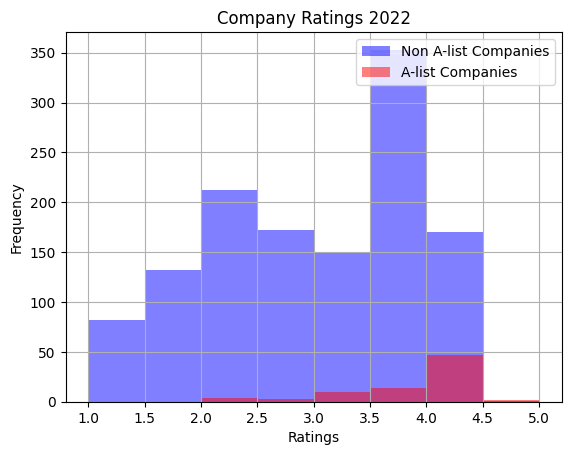

In [40]:

df_average_companies["Average"].hist(bins=[1,1.5,2,2.5,3,3.5,4,4.5,5], alpha = 0.5, label='Non A-list Companies', color='blue')

# plt.hist(df_average_companies["Average"], bins=[1,1.5,2,2.5,3,3.5,4,4.5,5], alpha = 0.5, label='Non A-list Companies', color='blue')
plt.hist(df_average_a_list_companies["Average"], bins=[1,1.5,2,2.5,3,3.5,4,4.5,5], alpha = 0.5, label='A-list Companies', color='red')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
hist_title = "Company Ratings " + year
plt.title(hist_title)
plt.legend(loc='upper right')

png_name = prefix + "rating_result_graphs" + "/" + year + "/Combined_average_ratings_" + year + ".png"
# plt.savefig(png_name)

Methods to calculate TVD and EMD

In [5]:
# method that calculates the total variation distance between two histograms
def calculate_tvd(hist1, hist2):
    # Normalize histograms to sum to 1 (convert to probability distributions)
    hist1 = hist1 / np.sum(hist1)
    hist2 = hist2 / np.sum(hist2)
    
    # Calculate the total variation distance
    tvd = 0.5 * np.sum(np.abs(hist1 - hist2))
    return tvd

from scipy.stats import wasserstein_distance


CREATE HISTOGRAM NORMALIZED

In [178]:
year = "2022"
# title = "one_reference"
# folder_name = "2022_all_companies_v2/prompt_v1_" + title
# folder_name = "2022_all_companies/prompt_v1_" + title

folder_name = "final_2022_all_companies/indicative_one_reference"


file_a = "rating_results/" + folder_name + "/average_ratings_a_list_results.csv"
file_b = "malicious_greenwashing_output/original/average_ratings_one_shot_indicative_results.csv"
# file_b = "rating_results/greenwashed_80_companies/strict_accuracy_strict_length/one_shot/average_ratings_greenwashed_results.csv"
# file_b = "rating_results/" + folder_name + "/average_ratings_non_a_list_results.csv" # original non a-list ratings
df_average_companies = pd.read_csv(file_b)
df_average_a_list_companies = pd.read_csv(file_a)

# bins = [round(x * 0.1, 1) for x in range(11, 51)]
# bins = [1,1.25, 1.25,1.75, 1.75,2.25, 2.25,2.75, 2.75,3.25, 3.25,3.75, 3.75,4.25, 4.25,4.75, 4.75,5]
# bins = [1,1.5, 1.5,2.5, 2.5,3.5, 3.5,4.5, 4.5,5]
# bins = [round(x * 0.25, 2) for x in range(4, 21)]
bins = [round(1 + x * 0.16, 2) for x in range(0, 26)]
bin_centers = [(bins[i] + bins[i + 1]) / 2 for i in range(len(bins) - 1)]



TVD =  0.42636138613861385
EMD =  0.7190759075907591


Text(0.02, 0.98, 'TVD = 0.426\nEMD = 0.719')

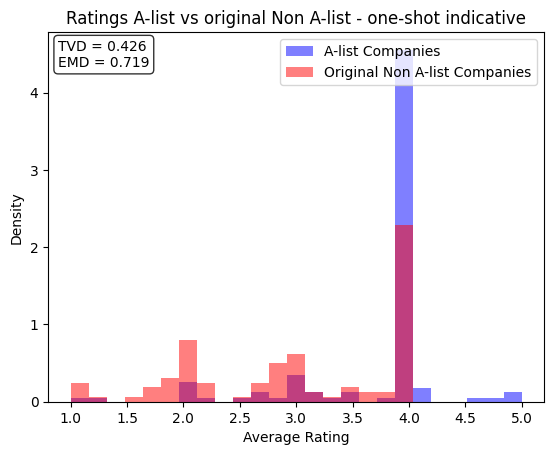

In [179]:
hist1,_ = np.histogram(df_average_a_list_companies["Average"], bins = bins)
hist2,_ = np.histogram(df_average_companies["Average"], bins = bins)

tvd = calculate_tvd(hist1, hist2)
print("TVD = ", tvd)

emd = wasserstein_distance(bin_centers, bin_centers, u_weights=hist1, v_weights=hist2)
print("EMD = ", emd)


plt.hist(df_average_a_list_companies["Average"], bins=bins, alpha = 0.5, label='A-list Companies', color='blue',density=True)
plt.hist(df_average_companies["Average"], bins=bins, alpha = 0.5, label='Original Non A-list Companies', color='red',density=True)
plt.xlabel('Average Rating')
plt.ylabel('Density')
hist_title = "Ratings A-list vs original Non A-list - one-shot indicative"
plt.title(hist_title)
plt.legend(loc='upper right')

text = f"TVD = {tvd:.3f}\nEMD = {emd:.3f}"
plt.text(0.02, 0.98, text, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

#png_name = prefix + "normalized_histogram.png"
#plt.savefig(png_name)

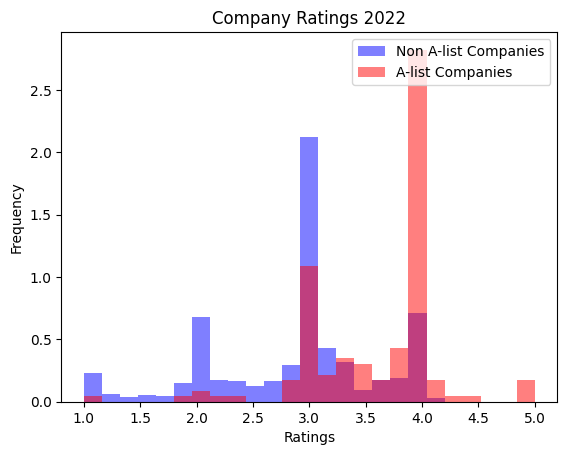

In [130]:

bin = [round(1 + x * 0.16, 2) for x in range(0, 26)]


plt.hist(df_average_companies["Average"], bins=bin, alpha = 0.5, label='Non A-list Companies', color='blue', density = True)
plt.hist(df_average_a_list_companies["Average"], bins=bin, alpha = 0.5, label='A-list Companies', color='red', density = True)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
hist_title = "Company Ratings " + year
plt.title(hist_title)
plt.legend(loc='upper right')

# png_name = prefix + "rating_result_graphs" + "/" + year + "/Combined_average_ratings_" + year + ".png"
# plt.savefig(png_name)

GET AVERAGE OF ALL SCORES

In [181]:
# get average score
file_name = "malicious_greenwashing_output/original/average_ratings_one_shot_indicative_results.csv"
avg_file = pd.read_csv(file_name)

avg = avg_file["Average"].mean()

print(avg)

3.0267158415841586


GET AVERAGE WORD COUNTS OF ORIGNAL VS 3 GREENWASHED VERSIONS

In [195]:
file_name = "malicious_greenwashing_output/original/101_new_responses.csv"
df_responses = pd.read_csv(file_name)

# df_responses['word_count'] = df_responses["New Response A"].str.split().str.len() + df_responses["New Response B"].str.split().str.len()
# print(df_responses['word_count'])
# print (df_responses['word_count'].mean())

# Combine the two columns into a single series, excluding NaN values
combined_columns = df_responses['Old Response A'].fillna('') + ' ' + df_responses['Old Response B'].fillna('')

# Function to count words in a string
def count_words(text):
    return len(text.split())

# Apply the word count function and compute the total and average
word_counts = combined_columns.apply(count_words)
total_words = word_counts.sum()
average_word_count = word_counts.mean()

print(f"Total Words: {total_words}")
print(f"Average Word Count: {average_word_count:.2f}")

Total Words: 23259
Average Word Count: 230.29


Compare indicative vs non indicative in a histogram

TVD =  0.28380503144654085


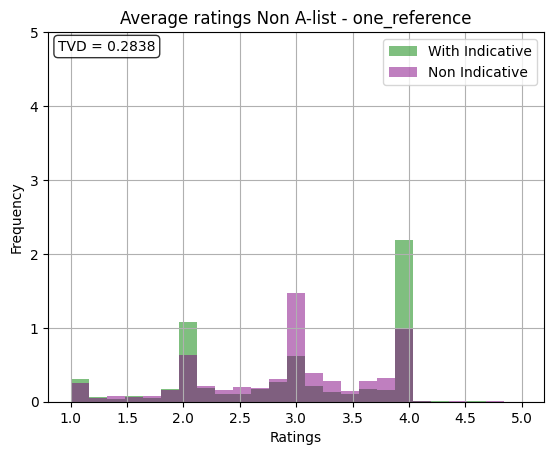

In [154]:
year = "2022"
title = "one_reference"
folder_name = "final_2022_all_companies/"
file_name = "/average_ratings_non_a_list_results.csv"

file_indicative = "rating_results/" + folder_name + "indicative_" + title + file_name
file_non_indicative = "rating_results/" + folder_name + title + file_name
df_average_companies_indicative = pd.read_csv(file_indicative)
df_average_companies_non_indicative = pd.read_csv(file_non_indicative)

bins = [round(1 + x * 0.16, 2) for x in range(0, 26)]

hist1,_ = np.histogram(df_average_companies_indicative["Average"], bins = bins)
hist2,_ = np.histogram(df_average_companies_non_indicative["Average"], bins = bins)

tvd = calculate_tvd(hist1, hist2)
print("TVD = ", tvd)


df_average_companies_indicative["Average"].hist(bins=bins, alpha = 0.5, label='With Indicative', color='green',density=True)

# plt.hist(df_average_companies["Average"], bins=[1,1.5,2,2.5,3,3.5,4,4.5,5], alpha = 0.5, label='Non A-list Companies', color='blue',density=True)
plt.hist(df_average_companies_non_indicative["Average"], bins=bins, alpha = 0.5, label='Non Indicative', color='purple',density=True)

y_max = 5
plt.ylim(0, y_max)

plt.xlabel('Ratings')
plt.ylabel('Frequency')
hist_title = "Average ratings Non A-list (one-shot)"
plt.title(hist_title)
plt.legend(loc='upper right')

tvd_text = f"TVD = {tvd:.4f}"
# plt.text(1.1, plt.ylim()[1] * 0.9, tvd_text, fontsize=12, color='black')  # Places TVD at 90% of y-limit for visibility
plt.text(0.02, 0.98, tvd_text, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))


plt.show()

#png_name = prefix + "normalized_histogram.png"
#plt.savefig(png_name)


Statistical analysis on average ratings

In [ ]:
# create a table for storing tvd, ks stat, p-value, and bhattacharyya distance for each year


Calculate total variation distance (TVD) for Logprob

In [57]:
# get data
year = "2022"
folder_name = "2022_all_companies/prompt_v1_reference_5_with_explanation"
# file_a = "rating_results/" + folder_name + "/average_ratings/a_list_average_ratings_" + year + ".csv"
# file_b = "rating_results/" + folder_name + "/average_ratings/non_a_list_average_ratings_" + year + ".csv"

# file_a = "rating_results/" + folder_name + "/average_ratings/a_list_two_reference.csv"
# file_b = "rating_results/" + folder_name + "/average_ratings/non_a_two_reference.csv"

file_a = "rating_results/" + folder_name + "/average_ratings_a_list_results.csv"
file_b = "rating_results/" + folder_name + "/average_ratings_non_a_list_results.csv"

df_a = pd.read_csv(file_a)
df_b = pd.read_csv(file_b)

# get histograms
# bins = [1,1.5,2,2.5,3,3.5,4,4.5,5]
bins = [1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4,4.25,4.5,4.75,5]

hist1,_ = np.histogram(df_a["Average"], bins = bins)
hist2,_ = np.histogram(df_b["Average"], bins = bins)

tvd = calculate_tvd(hist1, hist2)
print("TVD = ", tvd)

TVD =  0.46488469601677146


TVD for Output

In [78]:
# read data file and get "output" column (not logprob averages) for TVD calculations
# get data
folder_name = "2022_all_companies_v2/prompt_v1_indicative_reference_5"
# file_a = "rating_results/" + folder_name + "/average_ratings/a_list_average_ratings_" + year + ".csv"
# file_b = "rating_results/" + folder_name + "/average_ratings/non_a_list_average_ratings_" + year + ".csv"

file_a = "rating_results/" + folder_name + "/a_list_results.csv"
file_b = "rating_results/" + folder_name + "/non_a_list_results.csv"

df_a = pd.read_csv(file_a)
df_b = pd.read_csv(file_b)

# get histograms
# bins = [round(1 + x * 0.16, 2) for x in range(0, 26)]
# bins = [1,1.5,2,2.5,3,3.5,4,4.5,5]
bins = [1,2,3,4,5]

hist1,_ = np.histogram(df_a["Output"], bins = bins)
hist2,_ = np.histogram(df_b["Output"], bins = bins)

tvd = calculate_tvd(hist1, hist2)
print("TVD = ", tvd)

TVD =  0.42911425576519924


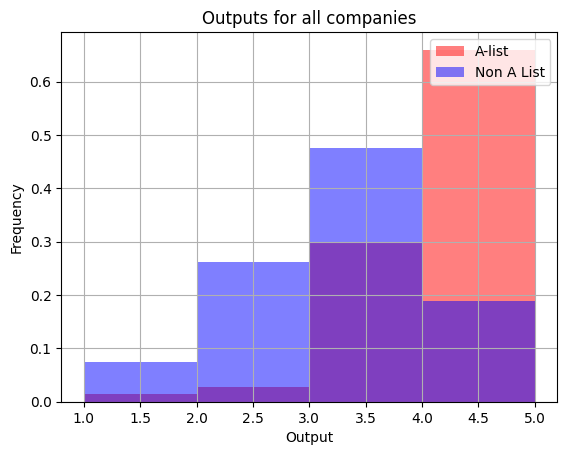

In [76]:
# histogram for output

# plt.figure(figsize=(10, 6))

# Plot histogram for df_a
df_a["Output"].hist(bins=bins, alpha = 0.5, label='A-list', color='red',density=True)

# plt.hist(df_a["Output"], bins=bins, alpha=0.5, label="A List", color='red', density=True)

# Plot histogram for df_b
plt.hist(df_b["Output"], bins=bins, alpha=0.5, label="Non A List", color='blue', density=True)

# Add labels and title
plt.xlabel('Output')
plt.ylabel('Frequency')
plt.title('Outputs for all companies')

# Add a legend
plt.legend(loc='upper right')

# Display the plot
plt.show()

# png_name = prefix + "normalized_histogram.png"
# plt.savefig(png_name)


Calculate KS statistic and P-value: Kolmogorov-Smirnov (KS) test

KS Statistic: 0.46003668763102723
P-value: 1.9294974844378878e-25
Cramér-von Mises Statistic: 12.631575282559908
P-value (CvM test): 2.7698209281723507e-09
Anderson-Darling Statistic: 88.92311129996396
P-value (AD test): 0.001


/var/folders/pd/d0rqwxkn6y9dmj15pn9l65cr0000gn/T/ipykernel_52884/1947451251.py:37: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_result = anderson_ksamp([df_a[col], df_b[col]])


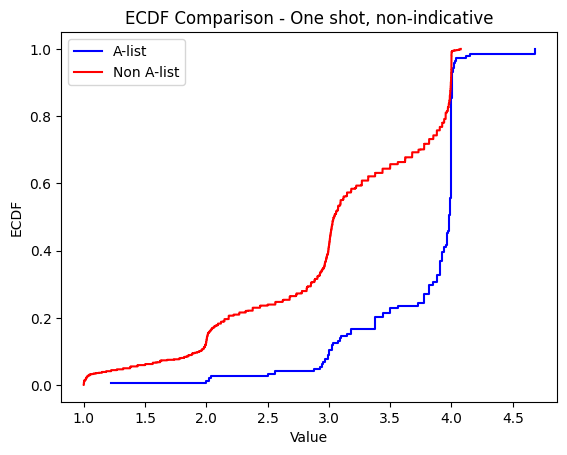

In [201]:
from scipy.stats import cramervonmises_2samp, anderson_ksamp

# get data
year = "2022"
# folder_name_a = "2022_all_companies/prompt_v1_"
folder_name_a = "final_2022_all_companies/two_reference"
# folder_name_b = "reference_3_and_5_with_explanation"
folder_name_b = "malicious_greenwashing_output/original/"

# for log prob averages
file_a = "rating_results/" + folder_name_a + "/average_ratings_a_list_results.csv"
file_b = "rating_results/" + folder_name_a + "/average_ratings_non_a_list_results.csv"
# file_b = folder_name_b + "/average_ratings_one_shot_indicative_results.csv"


# for output directly from results
# file_a = "rating_results/" + folder_name_a + folder_name_b + "/average_ratings_a_list_results.csv"
# file_b = "rating_results/" + folder_name_a + folder_name_b + "/average_ratings_non_a_list_results.csv"

df_a = pd.read_csv(file_a)
df_b = pd.read_csv(file_b)

# get column to read data from ("Average" for logprob or "Output")
col = "Average"

ks_statistic, p_value = stats.ks_2samp(df_a[col], df_b[col])
print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {p_value}")


# Cramér-von Mises statistic
cvm_result = cramervonmises_2samp(df_a[col], df_b[col])
print(f"Cramér-von Mises Statistic: {cvm_result.statistic}")
print(f"P-value (CvM test): {cvm_result.pvalue}")

# Anderson-Darling statistic
ad_result = anderson_ksamp([df_a[col], df_b[col]])
print(f"Anderson-Darling Statistic: {ad_result.statistic}")
print(f"P-value (AD test): {ad_result.significance_level}")

# Optional: Plot ECDFs based on raw data
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    x = np.sort(data)
    n = len(data)
    y = np.arange(1, n+1) / n
    return x, y

# Get ECDFs for both datasets
x1, y1 = ecdf(df_a[col])
x2, y2 = ecdf(df_b[col])

plt.step(x1, y1, label='A-list', where='post', color='blue')
plt.step(x2, y2, label='Non A-list', where='post', color='red')
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.title('ECDF Comparison - One shot, non-indicative')

# Annotate the KS and CvM results on the graph
# plt.text(0.05, 0.95, f'KS Statistic: {ks_statistic:.4f}\nP-value (KS): {p_value:.4f}', 
#          transform=plt.gca().transAxes, verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

# plt.text(0.05, 0.85, f'CvM Statistic: {cvm_result.statistic:.4f}\nP-value (CvM): {cvm_result.pvalue:.4f}', 
#          transform=plt.gca().transAxes, verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

# plt.text(0.05, 0.75, f'AD Statistic: {ad_result.statistic:.4f}\nP-value (AD): {ad_result.significance_level:.4f}', 
#          transform=plt.gca().transAxes, verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

plt.legend()
plt.show()

KS Statistic for range 1-3: 0.46497050147492625
P-value for range 1-3: 0.045802237326992554


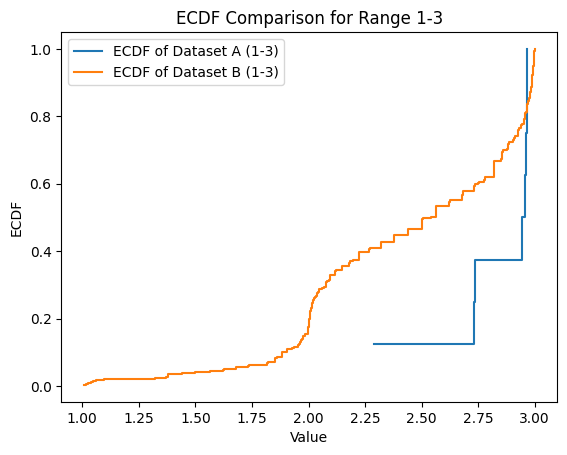

KS Statistic for range 3-5: 0.3513334594287876
P-value for range 3-5: 1.4219649980034805e-13


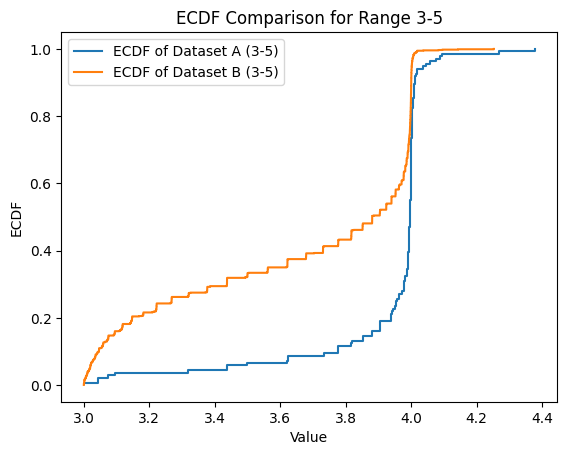

In [48]:
# Get the data
year = "2022"
# folder_name = "2022_all_companies_v2/prompt_v1_indicative_reference_3_and_5"
folder_name = "2022_all_companies/prompt_v1_no_reference"

file_a = "rating_results/" + folder_name + "/average_ratings_a_list_results.csv"
file_b = "rating_results/" + folder_name + "/average_ratings_non_a_list_results.csv"

df_a = pd.read_csv(file_a)
df_b = pd.read_csv(file_b)

# Define function to compute ECDF
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    x = np.sort(data)
    n = len(data)
    y = np.arange(1, n+1) / n
    return x, y

# Define ranges for subgroups (e.g., 1-3 and 3-5)
ranges = [(1, 3), (3, 5)]

for r_min, r_max in ranges:
    # Filter data based on the defined range
    df_a_range = df_a[(df_a["Average"] >= r_min) & (df_a["Average"] <= r_max)]
    df_b_range = df_b[(df_b["Average"] >= r_min) & (df_b["Average"] <= r_max)]
    
    # Calculate KS statistic and p-value for the range
    if len(df_a_range) > 0 and len(df_b_range) > 0:  # Ensure data exists in both ranges
        ks_statistic, p_value = stats.ks_2samp(df_a_range["Average"], df_b_range["Average"])
        print(f"KS Statistic for range {r_min}-{r_max}: {ks_statistic}")
        print(f"P-value for range {r_min}-{r_max}: {p_value}")
        
        # Get ECDFs for both datasets
        x1, y1 = ecdf(df_a_range["Average"])
        x2, y2 = ecdf(df_b_range["Average"])
        
        # Plot ECDFs
        plt.step(x1, y1, label=f'ECDF of Dataset A ({r_min}-{r_max})', where='post')
        plt.step(x2, y2, label=f'ECDF of Dataset B ({r_min}-{r_max})', where='post')
        plt.xlabel('Value')
        plt.ylabel('ECDF')
        plt.title(f'ECDF Comparison for Range {r_min}-{r_max}')
        plt.legend()
        plt.show()
    else:
        print(f"No data available for the range {r_min}-{r_max}")


CALCULATE CRAMER TEST

Statistic: 12.723694937092105, p-value: 3.125718572860592e-09


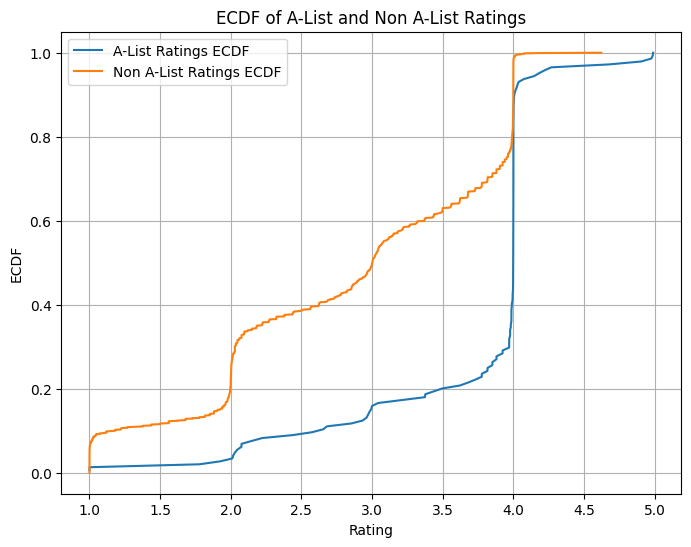

In [61]:
from scipy.stats import cramervonmises_2samp
import matplotlib.pyplot as plt


# Get the data
year = "2022"
folder_name = "2022_all_companies_v2/prompt_v1_indicative_reference_5"
# folder_name = "2022_all_companies/prompt_v1_indicative_no_reference"

file_a = "rating_results/" + folder_name + "/average_ratings_a_list_results.csv"
file_b = "rating_results/" + folder_name + "/average_ratings_non_a_list_results.csv"

df_a = pd.read_csv(file_a)
df_b = pd.read_csv(file_b)

ratings_a = df_a['Average'].values 
ratings_b = df_b['Average'].values

# Perform the Cramér–von Mises two-sample test
result = cramervonmises_2samp(ratings_a, ratings_b)

# Print the result
print(f"Statistic: {result.statistic}, p-value: {result.pvalue}")

# Print ECDF graph

def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

# Compute ECDF for both datasets
x_a, y_a = ecdf(ratings_a)
x_b, y_b = ecdf(ratings_b)

# Plot the ECDF
plt.figure(figsize=(8, 6))
plt.plot(x_a, y_a, label="A-List Ratings ECDF")
plt.plot(x_b, y_b, label="Non A-List Ratings ECDF")

plt.title('ECDF of A-List and Non A-List Ratings')
plt.xlabel('Rating')
plt.ylabel('ECDF')
plt.legend()
plt.grid(True)
plt.show()

Calculate Bhattacharyya distance

In [173]:
def bhattacharyya_distance(hist1, hist2):
    
    # Ensure histograms are normalized (i.e., they sum to 1)
    hist1 = hist1 / np.sum(hist1)
    hist2 = hist2 / np.sum(hist2)
    
    # Calculate the Bhattacharyya coefficient
    bc = np.sum(np.sqrt(hist1 * hist2))
    
    # Calculate the Bhattacharyya distance
    distance = -np.log(bc)
    
    return distance

In [174]:
# get data
# year = "2022"
# folder_name = "50_a_vs_non_a_with_example"
# file_a = "rating_results/" + folder_name + "/average_ratings/a_list_average_ratings_" + year
# file_b = "rating_results/" + folder_name + "/average_ratings/non_a_list_average_ratings_" + year

# df_a = pd.read_csv(file_a)
# df_b = pd.read_csv(file_b)

# get histograms
bins = [1,1.5,2,2.5,3,3.5,4,4.5,5]
bins = [1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4,4.25,4.5,4.75,5]
hist1,_ = np.histogram(df_a["Average"], bins = bins)
hist2,_ = np.histogram(df_b["Average"], bins = bins)

distance = bhattacharyya_distance(hist1, hist2)
print("bhattacharyya distance = ", distance)

bhattacharyya distance =  0.20608276348986276


THRESHOLD TESTING
1. for each year, split data into training and testing sets


In [277]:
from sklearn.model_selection import train_test_split

In [327]:
# get csv files
year = "2018"

# pairwise files
file_a = "pairwise_files/two_runs_per_pair/" + year + "_A_List_Average.csv"
file_non_a = "pairwise_files/two_runs_per_pair/" + year + "_Non_A_List_Average.csv"

# rating files
# data_path = "rating_results/8-13_no_reference_based_on_8_7_redacted/"
# file_a = data_path + "average_ratings/a_list_average_ratings_" + year + ".csv"
# file_non_a = data_path + "average_ratings/non_a_list_average_ratings_" + year + ".csv"

# read csv files to get data
df_a = pd.read_csv(file_a)
df_non_a = pd.read_csv(file_non_a)

# split into train and test sets (50-50)
a_train, a_test, non_a_train, non_a_test = train_test_split(df_a["Average"], df_non_a["Average"], test_size=0.5, random_state=42)

# record best threshold based on best tp+tn, tp, and tn rates
best_threshold_tp_tn = 0
highest_tp_tn = 0

best_threshold_tp = 0
highest_tp = 0

best_threshold_tn = 0
highest_tn = 0

# result file for accuracy per threshold
df_results = pd.DataFrame(columns=["Threshold", "TP", "TN", "FP", "FN"])

# test each threshold between 1 and 5 with 0.1 increments (divide by 10 to get threshold)
# for threshold in range(10,51):
#     threshold = threshold/10
for threshold in range(1,100):
    # keep track of accuracy with tp, tn, fp, fn
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    # go through a_train data
    for average in a_train:
        if average >= threshold:
            tp += 1
        elif average < threshold:
            fn += 1
    # go through non_a_train data
    for average in non_a_train:
        if average >= threshold:
            fp += 1
        elif average < threshold:
            tn += 1
    
    # write threshold, tp, tn, fp, fn values to results_df
    temp_df = pd.DataFrame([{'Threshold': threshold, 'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn}])
    df_results = pd.concat([df_results, temp_df], ignore_index=True)

    # update best thresholds
    if (tp + tn) >= highest_tp_tn:
        highest_tp_tn = tp + tn
        best_threshold_tp_tn = threshold
    if (tp) >= highest_tp:
        highest_tp = tp
        best_threshold_tp = threshold
    if (tn) > highest_tn:
        highest_tn = tn
        best_threshold_tn = threshold

# write results to csv file
# df_results.to_csv(data_path + 'analysis/threshold_results_' + year + '.csv', index=False)
df_results.to_csv("pairwise_files/analysis/threshold_results_" + year + ".csv", index=False)
print (best_threshold_tp_tn)
print(best_threshold_tp)
print(best_threshold_tn)


# test on test data sets
tp,tn,fp,fn = 0,0,0,0
# go through a_test data
for average in a_test:
    if average >= best_threshold_tp_tn:
        tp += 1
    elif average < best_threshold_tp_tn:
        fn += 1
# go through non_a_test data
for average in non_a_test:
    if average >= best_threshold_tp_tn:
        fp += 1
    elif average < best_threshold_tp_tn:
        tn += 1

print("test results")
print(tp)
print(tn)
print(fp)
print(fn)

61
39
83
test results
15
20
5
10


SCATTERPLOT OF LENGTH VS RATING SCORE

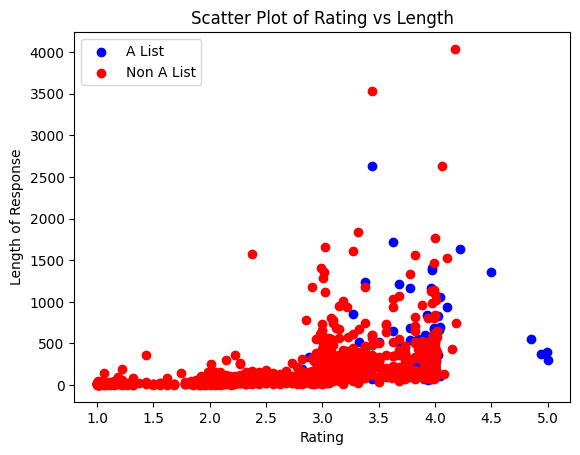

In [55]:
# read in 2022 merged data file to get length of responses for each company
# create file with company name and length of response

data_file_name = "merged_files/2022_merged_dataset.csv"
data_file = pd.read_csv(data_file_name)

# get just wanted non a companies
company_file_name = "rating_results/2022_all_companies_v2/prompt_v1_reference_5/non_a_list_results.csv"
company_df = pd.read_csv(company_file_name)
companies_to_extract_non_a = company_df["Company"]
data_file_non_a = data_file[data_file['Organization'].isin(companies_to_extract_non_a)]
indices_non_a = data_file_non_a.index

# get just wanted a companies
company_file_name = "rating_results/2022_all_companies_v2/prompt_v1_reference_5/a_list_results.csv"
company_df = pd.read_csv(company_file_name)
companies_to_extract_a = company_df["Company"]
data_file_a = data_file[data_file['Organization'].isin(companies_to_extract_a)]
indices_a = data_file_a.index

response_list_4a_non_a = data_file_non_a[data_file_non_a.columns[5]]
response_list_4b_non_a = data_file_non_a[data_file_non_a.columns[6]]

response_list_4a_a = data_file_a[data_file_a.columns[5]]
response_list_4b_a = data_file_a[data_file_a.columns[6]]


len_non_a = []
len_a = []
      
for i in indices_non_a:
    len1 = 0
    len2 = 0
    if isinstance(response_list_4a_non_a[i], str):
        len1 = len(response_list_4a_non_a[i].split())
    if isinstance(response_list_4b_non_a[i], str):
        len2 = len(response_list_4b_non_a[i].split())
    
    len_non_a.append(len1+len2)

for i in indices_a:
    len1 = 0
    len2 = 0
    if isinstance(response_list_4a_a[i], str):
        len1 = len(response_list_4a_a[i].split())
    if isinstance(response_list_4b_a[i], str):
        len2 = len(response_list_4b_a[i].split())
    
    len_a.append(len1+len2)

# get ratings
ratings_non_a = pd.read_csv("rating_results/2022_all_companies_v2/prompt_v1_reference_5/average_ratings_non_a_list_results.csv")
ratings_a = pd.read_csv("rating_results/2022_all_companies_v2/prompt_v1_reference_5/average_ratings_a_list_results.csv")

# plot companies ratings vs len lists
x1 = ratings_a["Average"]
y1 = len_a
x2 = ratings_non_a["Average"]
y2 = len_non_a

plt.scatter(x1, y1, color='blue', label='A List')
plt.scatter(x2, y2, color='red', label='Non A List')

# Add labels and title
plt.xlabel('Rating')
plt.ylabel('Length of Response')
plt.title('Scatter Plot of Rating vs Length')

# Add a legend
plt.legend()

# Show the plot
plt.show()

Get response length for statistics for paper

In [54]:
# read in 2022 merged data file to get length of responses for each company

data_file_name = "merged_files/2020_merged_dataset.csv"
data_file = pd.read_csv(data_file_name)

# response lists of all companies
response_list_4a = data_file[data_file.columns[5]]
response_list_4b = data_file[data_file.columns[6]]

total_len = []

for i in range(len(response_list_4a)):
    len1 = 0
    len2 = 0
    if isinstance(response_list_4a[i], str):
        len1 = len(response_list_4a[i].split())
    if isinstance(response_list_4b[i], str):
        len2 = len(response_list_4b[i].split())
    
    # if (len1 < 2):
    #     print("1", response_list_4a[i], type(response_list_4a[i]))
    # if (len2 < 2):
    #     print("2", response_list_4b[i], type(response_list_4b[i]))
    if (len1+len2 <= 4):
        print("combined", response_list_4a[i], ";", response_list_4b[i])

    
    total_len.append(len1+len2)

# get avg, std, max, min
avg = sum(total_len) / len(total_len)
print("avg: ", avg)

variance = sum([((x - avg) ** 2) for x in total_len]) / len(total_len) 
std = variance ** 0.5
print("std: ", std)

print("max: ", max(total_len))
print("min: ", min(total_len))


print("numbers after removing chinese")

total_len.sort()
total_len = total_len[1:]

# get avg, std, max, min
avg = sum(total_len) / len(total_len)
print("avg: ", avg)

variance = sum([((x - avg) ** 2) for x in total_len]) / len(total_len) 
std = variance ** 0.5
print("std: ", std)

print("max: ", max(total_len))
print("min: ", min(total_len))



combined 2019年目标年度范围一加二的数值。 ; 2019年目标年度范围一加二的数值。
combined Reduction was acchieved ; nan
combined Reduction of solvent emission ; nan
avg:  279.15758980301274
std:  343.18988012659355
max:  3044
min:  2
numbers after removing chinese
avg:  279.47911832946636
std:  343.2589565923855
max:  3044
min:  3


SCATTERPLOT OF RATING SCORE VS PAIRWISE SCORE

0.7306309072812582


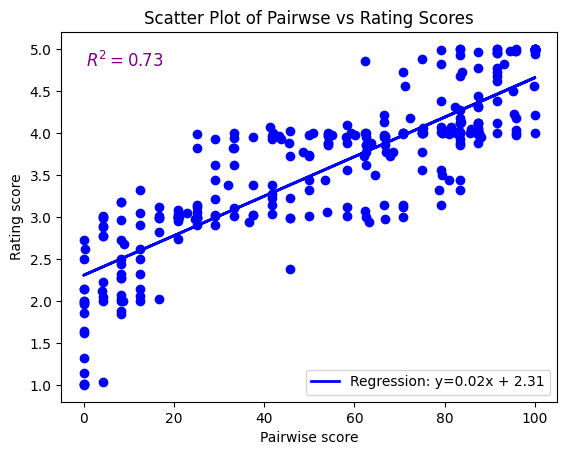

In [111]:
# read in pairwise score file and rating score file
pairwise_file_a_list = pd.read_csv("Part_1_Company_Testing/147_147_Companies/147_A_List_Pairwise_Averages.csv")
pairwise_file_non_a_list = pd.read_csv("Part_1_Company_Testing/147_147_Companies/147_Non_A_List_Pairwise_Averages.csv")

# x1 is pairwise a list
# x2 is pairwise non a list
x1 = pairwise_file_a_list["Weighted_Average"]
x2 = pairwise_file_non_a_list["Weighted_Average"]

# from x1 and x2, create y1 and y2 lists for corresponding rating scores
rating_file_a_list = pd.read_csv("rating_results/2022_all_companies/prompt_v1_reference_5/average_ratings_a_list_results.csv")
rating_file_non_a_list = pd.read_csv("rating_results/2022_all_companies/prompt_v1_reference_5/average_ratings_non_a_list_results.csv")

y1 = []
y2 = []

for company in pairwise_file_a_list["Company"]:
    row = rating_file_a_list.loc[rating_file_a_list['Company'] == company]
    y1.append(row["Average"].iloc[0])

for company in pairwise_file_non_a_list["Company"]:
    row = rating_file_non_a_list.loc[rating_file_non_a_list['Company'] == company]
    y2.append(row["Average"].iloc[0])

# Convert x1, y1, x2, y2 to numpy arrays and reshape x1, x2 to be 2D arrays
x1 = np.array(x1).reshape(-1, 1)  # Reshape to 2D array for LinearRegression
y1 = np.array(y1)
x2 = np.array(x2).reshape(-1, 1)  # Reshape to 2D array for LinearRegression
y2 = np.array(y2)

# combine x and y
x_combined = np.vstack((x1, x2))
y_combined = np.concatenate((y1, y2))

plt.scatter(x_combined, y_combined, color='blue')
# plt.scatter(x2, y2, color='red', label='Non A List')

# Perform linear regression for A List
model_a_list = LinearRegression()
model_a_list.fit(x_combined, y_combined)
y1_pred = model_a_list.predict(x_combined)

# # Perform linear regression for Non-A List
# model_non_a_list = LinearRegression()
# model_non_a_list.fit(x2, y2)
# y2_pred = model_non_a_list.predict(x2)

# Plot the regression lines
plt.plot(x_combined, y1_pred, color='blue', linewidth=2, label=f'Regression: y={model_a_list.coef_[0]:.2f}x + {model_a_list.intercept_:.2f}')
# plt.plot(x2, y2_pred, color='red', linewidth=2, label=f'Non A List Regression: y={model_non_a_list.coef_[0]:.2f}x + {model_non_a_list.intercept_:.2f}')

r_squared_a = model_a_list.score(x_combined,y_combined)
# r_squared_non_a = model_a_list.score(x_combined,y_combined)

print(r_squared_a)
# print(r_squared_non_a)
plt.text(0.05, 0.95, f'$R^2 = {r_squared_a:.2f}$', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', color='purple')


# Add labels and title
plt.xlabel('Pairwise score')
plt.ylabel('Rating score')
plt.title('Scatter Plot of Pairwse vs Rating Scores')

# Add a legend
plt.legend()

# Show the plot
plt.show()
